# Alzheimer's Disease classification from anatomical MRI

## Exploring the classification of different imaging features using a random forest model
(Code deployed in Jupyter notebook using a PySpark kernel leveraging Apache Hadoop)

In [1]:
# import analysis and plotting libraries

# "standard"
import numpy as np
import pandas as pd

# machine learning
import pyspark
from pyspark.sql import SparkSession
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Parallel computing
import dask
from dask.distributed import Client, progress
from dask.diagnostics import ProgressBar

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import cv2
import magic
from IPython.display import clear_output

In [ ]:
# import pyspark module
spark = SparkSession.builder.appName("Brad's PySpark").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

## Load and format train and test data

In [2]:
# load training data
BASE_DIR = "C:/Users/bedelman/Documents\GitHub/Alzheimers-MRI-Classification/Alzheimer_MRI_Dataset/Data/"

'''
Label meanings
0 - Mild dementia
1 - Moderate dementia
2 - No dementia
3 - Very mild dementia
'''
Lab = ['Mild', 'Moderate', 'None', 'Very Mild']

train = pd.read_parquet(f"{BASE_DIR}/train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow")
train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [3]:
# Convert data to readable format

def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

train['img_arr'] = train['image'].apply(dict_to_image)
train.drop("image", axis=1, inplace=True)
train.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [4]:
# Load test data

test = pd.read_parquet(f"{BASE_DIR}/test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")
test.head() 

# Also convert to readable format
test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis=1, inplace=True)
test.head()

,label,img_arr
0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Explore structure and visualization of the data

Text(0, 0.5, '# of images')

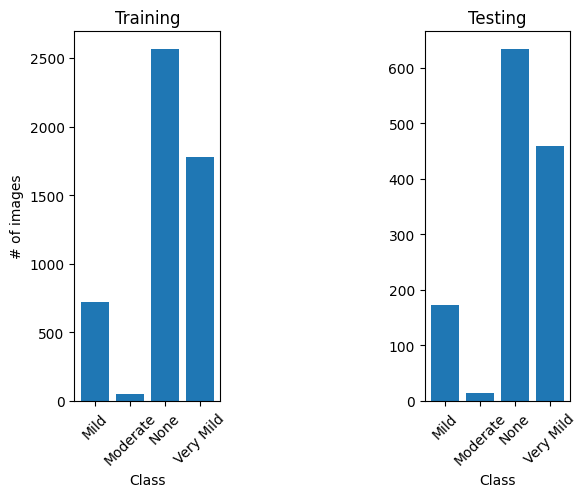

In [5]:
# what is the distribution of the datasets (are all classes represented equally?)

f, ax = plt.subplots(1,3)
unique, counts = np.unique(np.asarray(train.iloc[:].label), return_counts = True)
ax[0].bar(unique, counts)
ax[0].set_xticks(unique)
ax[0].set_xticklabels(Lab, rotation = 45)
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('# of images')

ax[1].axis('off')

unique, counts = np.unique(np.asarray(test.iloc[:].label), return_counts = True)
ax[2].bar(unique, counts)
ax[2].set_xticks(unique)
ax[2].set_xticklabels(Lab, rotation = 45)
ax[2].set_title('Testing')
ax[2].set_xlabel('Class')
ax[0].set_ylabel('# of images')

# An obvious imbalance across classes, but each class seems to be balanced across training/testing sets

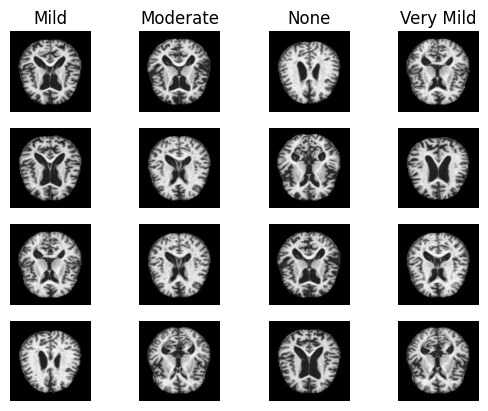

In [13]:
# visually inspect some of the data

train_lab_idx = np.asarray(train.iloc[:].label)

f, ax = plt.subplots(4,4)
for lab in range(4):
    for ex in range(4):
    
        class_lab = np.argwhere(train_lab_idx == 1)
        current_idx = np.random.randint(len(class_lab)-1,size = 1)
        current_idx = np.asarray(current_idx)
        
        ax[ex, lab].axis('off')
        ax[ex, lab].imshow(train.iloc[class_lab[current_idx[0]][0]].img_arr, cmap = "gray")
        if ex == 0: ax[ex, lab].set_title(Lab[lab])

# Clearly, images show different slices within the brain, which may be a major confound...

# Feature engineering for visualization and classification

- raw pixel intensity X PCA
- histogram of oriented gradients
- segmented brain volume


Text(0, 0.5, 'Variance Explained')

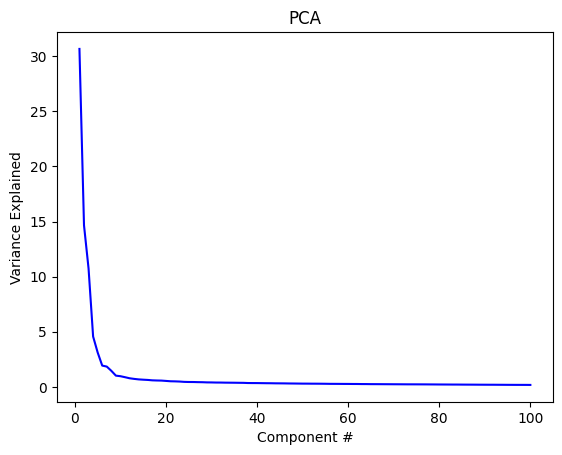

In [15]:
# PCA on raw pixel data

train_data = []
for i in range(len(train)):
    train_data.append(np.reshape(train.iloc[i].img_arr, (1, -1)))    
train_data = np.vstack(train_data[:])

# decompose with PCA and look at various metrics/info
pca = PCA(n_components = 100)
pca.fit(train_data)

plt.plot(np.linspace(1,100,100),pca.explained_variance_[:100]/sum(pca.explained_variance_[:100])*100,'b')
plt.title('PCA')
plt.xlabel('Component #')
plt.ylabel('Variance Explained')

Text(0, 0.5, 'PC 2')

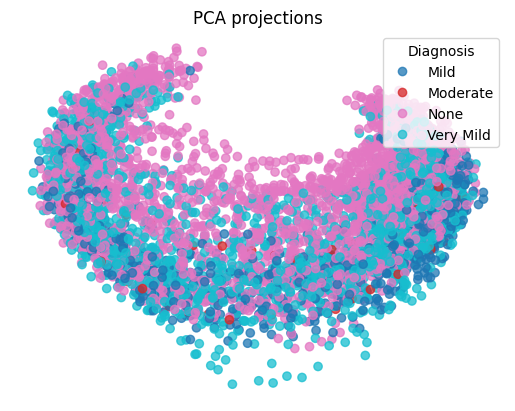

In [16]:
# Project training data into PCA space to visualize potential clustering
## first two PC's for simple visualization

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
load_train = np.matmul(train_data, loadings[:,:2])

# plot first two PCs
s  = plt.scatter(load_train[:,0], load_train[:,1], c = train_lab_idx*2, cmap = 'tab10', alpha = 0.75)
handles, labels = s.legend_elements()
legend = plt.legend(handles = handles, labels = Lab, title = 'Diagnosis', loc = 'upper right')
plt.axis('off')
plt.title('PCA projections')
plt.xlabel('PC 1')
plt.ylabel('PC 2')


## Preliminary random forest classification using first two PCs

In [17]:
# Train random forest classifier and apply to test data
## for now again only with first two PCs

rf_1 = RandomForestClassifier()

# Train classifier
load_train = np.matmul(train_data, loadings[:,:2])
rf_1.fit(load_train, train_lab_idx)

# Properly format test data and extract same features (PC loadings)
test_data = []
for i in range(len(test)):
    test_data.append(np.reshape(test.iloc[i].img_arr, (1, -1)))    
test_data = np.vstack(test_data[:])

load_test = np.matmul(test_data, loadings[:,:2])

# Predict unseen data
predictions_1 = rf_1.predict(load_test)
test_lab_idx = np.asarray(test.iloc[:].label)

# compare predictions with test labels and compute accuracy
result = predictions_1 - test_lab_idx
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary,0)
acc = correct/test_lab_idx.shape[0]*100
print(acc)

# When using the top two PCs, we see a modest classification rate on the test set. 
## However, using two PC's here is arbitrary due to easy visualization purposes.
## We can also exmaine accuracy as a function of the number of PCs and visualize the PC loading maps to interpret the classification results

48.359375


## Permutation testing on shuffled data as a control

### Parellelize time-consuming iterative processes (here with Dask)

In [23]:
client = Client(threads_per_worker = 5, n_workers = 2)
client

C:\Users\bedelman\Desktop\PySpark_proj\my_venv\lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59737 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:59737/status,
Dashboard: http://127.0.0.1:59737/status,Workers: 2
Total threads: 10,Total memory: 15.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59740,Workers: 2
Dashboard: http://127.0.0.1:59737/status,Total threads: 10
Started: Just now,Total memory: 15.59 GiB
Comm: tcp://127.0.0.1:59755,Total threads: 5
Dashboard: http://127.0.0.1:59756/status,Memory: 7.79 GiB
Nanny: tcp://127.0.0.1:59743,


In [41]:
# Shuffle data labels in the train set when building RF classifier to evaluate "chance" level 
## we'll do this a number of times to generate a sufficient null distribution

test_lab_idx = np.asarray(test.iloc[:].label)
train_lab_idx_shuffle = train_lab_idx
load_train = np.matmul(train_data, loadings[:,:2])

rng = np.random.default_rng()

def classification_RF_shuffle(load_train2, train_lab_idx_shuffle, load_test, test_lab_idx):
    
    # Train classifier with new shuffled labels each iteration
    rf_1 = RandomForestClassifier()
    rng.shuffle(train_lab_idx_shuffle)
    rf_1.fit(load_train, train_lab_idx_shuffle)

    # Predict unseen data
    predictions_1 = rf_1.predict(load_test)
    test_lab_idx = np.asarray(test.iloc[:].label)

    # compare predictions with test labels and compute accuracy
    result = predictions_1 - test_lab_idx
    result_binary = np.argwhere(result == 0)
    correct = np.size(result_binary,0)
    acc = correct/test_lab_idx.shape[0]*100
    return acc

# Parallelize lazy function to reduce computation time
## limit number of iterations in this function to account for computer memory limit
def iteration(load_train, train_lab_idx_shuffle, load_test, test_lab_idx):
    
    acc_shuffle = []
    for i in range(50):
        acc_tmp = dask.delayed(classification_RF_shuffle)(load_train, train_lab_idx_shuffle, load_test, test_lab_idx)
        acc_shuffle.append(acc_tmp)
    
    # compute values
    acc_shuffle = dask.compute(*acc_shuffle)
    acc_shuffle = np.array([float(num) for num in acc_shuffle])
    return acc_shuffle

In [ ]:
%%time
# Permute a sufficient number of times
## Not the most efficient way to do this, but again memory consideration on local machine

acc_shuffle_compile = []
for i in range(10):
    acc_tmp = iteration(load_train, train_lab_idx_shuffle, load_test, test_lab_idx)
    acc_shuffle_compile = np.concatenate((acc_shuffle_compile, acc_tmp), axis=0)
    clear_output(wait = True)

b = plt.boxplot(acc_shuffle_compile)
plt.title('Shuffled Classification Accuracy')
plt.xlabel('Shuffled')
plt.ylabel('Accuracy (%)')
plt.ylim(30, 60)

C:\Users\bedelman\Desktop\PySpark_proj\my_venv\lib\site-packages\distributed\client.py:3371: UserWarning: Sending large graph of size 20.19 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [51]:
%%time

# simple test to ensure that parallel processing is faster

# traditional for loop
acc_shuffle = []
for i in range(100):
    acc_tmp = classification_RF_shuffle(load_train, train_lab_idx, load_test, test_lab_idx)
    acc_shuffle.append(acc_tmp)

print(acc_shuffle)

[43.359375, 44.921875, 43.515625, 45.390625, 42.8125, 45.46875, 45.46875, 42.96875, 43.203125, 43.59375, 43.203125, 40.3125, 43.046875, 42.578125, 42.1875, 41.875, 43.984375, 41.5625, 43.125, 44.375, 42.8125, 41.25, 43.828125, 42.03125, 43.75, 44.21875, 40.0, 42.8125, 41.015625, 40.0, 45.546875, 43.046875, 43.515625, 41.171875, 43.359375, 42.265625, 42.109375, 42.96875, 42.5, 44.21875, 45.46875, 42.8125, 41.953125, 42.34375, 42.578125, 43.359375, 41.640625, 40.3125, 42.8125, 43.4375, 42.109375, 44.0625, 40.703125, 44.53125, 41.09375, 43.359375, 41.484375, 42.34375, 40.546875, 42.578125, 42.578125, 39.296875, 43.59375, 40.9375, 43.046875, 46.25, 44.84375, 44.140625, 43.984375, 43.359375, 44.84375, 41.71875, 43.359375, 42.8125, 43.515625, 43.125, 44.375, 43.046875, 41.5625, 44.296875, 43.75, 41.25, 42.8125, 44.0625, 43.828125, 42.109375, 42.34375, 45.234375, 43.28125, 43.59375, 41.953125, 44.140625, 43.59375, 45.234375, 43.203125, 41.796875, 41.953125, 42.734375, 47.34375, 42.5]
CPU time

In [30]:
%%time

# dask parallelization
acc_shuffle = []
for i in range(5):
    acc_tmp = dask.delayed(classification_RF_shuffle)(load_train, train_lab_idx, load_test, test_lab_idx)
    acc_shuffle.append(acc_tmp)
    
acc_shuffle = dask.compute(*acc_shuffle)
acc_shuffle = np.array([float(num) for num in acc_shuffle])
print(acc_shuffle)

C:\Users\bedelman\Desktop\PySpark_proj\my_venv\lib\site-packages\distributed\client.py:3371: UserWarning: Sending large graph of size 20.18 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


[41.5625   41.40625  41.640625 42.03125  41.5625  ]
CPU times: total: 422 ms
Wall time: 4.15 s


In [35]:
# Determine significance of previous classification accuracy

null_above_value = (acc_shuffle > acc).sum()
p_value = null_above_value/np.size(acc_shuffle,0)
print(p_value)

# We can see here that the classification accuracy is not sigificcantly different from chance with p-value > 0.05

TypeError: '>' not supported between instances of 'list' and 'float'

## Now explore classification as a function of PCs

In [194]:
%%time

# Test set classification as a function of PCs

def classification_RF_PCs(num_pc, load_train, train_lab_idx, load_test, test_lab_idx):

    load_train = np.matmul(train_data, loadings[:,:num_pc])

    rf_1 = RandomForestClassifier()
    rf_1.fit(load_train, train_lab_idx)
    
    load_test = np.matmul(test_data, loadings[:,:num_pc])

    # Predict unseen data
    predictions_1 = rf_1.predict(load_test)
    test_lab_idx = np.asarray(test.iloc[:].label)
    
    # compare predictions with test labels and compute accuracy
    result = predictions_1 - test_lab_idx
    result_binary = np.argwhere(result == 0)
    correct = np.size(result_binary,0)
    acc = correct/test_lab_idx.shape[0]*100
    return acc

# Parallelize classification
acc_PC = []
for i in range(len(loadings)):
    acc_tmp = dask.delayed(classification_RF_PCs)(i, load_train, train_lab_idx, load_test, test_lab_idx)
    acc_PC.append(acc_tmp)

# # compute values
# acc_PC = dask.compute(*acc_PC)
# acc_PC = np.array([float(num) for num in acc_PC])

# # plot accuracy as a function of PCs
# plt.plot(np.linspace(1,np.size(loadings,1)-1, np.size(loadings,1)-1), acc_PC, 'k')
# plt.title('Classification accuracy')
# plt.xlabel('Component #')
# plt.ylabel('Accuracy (%)')
# plt.ylim(30, 60)

CPU times: total: 1.06 s
Wall time: 1.1 s


In [218]:
acc_PC = dask.compute(*acc_PC)
acc_PC = np.array([float(num) for num in acc_PC])
acc_PC

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2980253350.py, line 1)

In [ ]:
%%time

# Also permute train labels for each number of PCs

def classification_RF_PC_shuffle(num_pc, load_train, train_lab_idx_shuffle, load_test, test_lab_idx):
    
    # Train classifier with new shuffled labels each iteration
    rf_1 = RandomForestClassifier()
    rng.shuffle(train_lab_idx_shuffle)
    rf_1.fit(load_train, train_lab_idx_shuffle)

    # Predict unseen data
    predictions_1 = rf_1.predict(load_test)
    test_lab_idx = np.asarray(test.iloc[:].label)

    # compare predictions with test labels and compute accuracy
    result = predictions_1 - test_lab_idx
    result_binary = np.argwhere(result == 0)
    correct = np.size(result_binary,0)
    acc = correct/test_lab_idx.shape[0]*100
    return acc

# Parallelize lazy function 500 times
acc_PC_shuffle = []
for i in range(500):
    acc_tmp = dask.delayed(classification_RF_PC_shuffle)(i, load_train, train_lab_idx, load_test, test_lab_idx)
    acc_PC_shuffle.append(acc_tmp)

# compute values
acc_shuffle = dask.compute(*acc_shuffle)


b = plt.boxplot(acc_shuffle)
plt.title('Shuffled Classification Accuracy')
plt.xlabel('Shuffled')
plt.ylabel('Accuracy (%)')

In [ ]:
# Visualize PC's to identify spatial features that contribute to data variance and subsequent classification

f, ax = plt.subplots(5,4)
lim = 20
for ipc in range(lim):

    PC_map = loadings[:,ipc]
    PC_map = np.reshape(PC_map, (128,128))
    clim = max(abs(np.min(PC_map)), abs(np.max(PC_map)))

    idx1 = np.floor(ipc/4).astype(int)
    idx2 = np.fmod(ipc,4)
    ax[idx1, idx2].axis('off')
    ax[idx1, idx2].imshow(PC_map, cmap = "magma", vmin = -clim, vmax = clim)
    ax[idx1, idx2].set_title(f'PC# {ipc +1}', fontsize = 10)
    plt.tight_layout()
    
    
